In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pickle as cp

from PIL import ImageFont, ImageDraw, Image
import glob
import os
# GLOBALS

In [57]:
# GLOBALS
with open('../input/imnames.cp.1', 'rb') as f:
  filtered_imnames = set(cp.load(f))
BGS =  list(filtered_imnames)
BGS = ["../input/bg_img/bg_img/"+t for t in BGS]
len(BGS)  
DFENG = pd.read_csv("../input/text/english.csv")
ENGLISH_PHRASES = DFENG["English"].tolist()
PROB_UPPERCASE = 0.5
FONTS = glob.glob("../input/font_cp/*.ttf")
TEXTURES = glob.glob("../input/textures/archive/dtd/images/*/*.jpg")
NUM_IMAGES = 10
# UTILS
def step1():
    # read bg image
    bg_img = cv2.imread(np.random.choice(BGS))
    # pick a shape for board
    shape_chosen = np.random.choice(["rectangle","circle"],p=[0.5,0.5])
    # pick bg color
    bg_color = list(np.random.randint(low=0, high=255, size=3))
    bg_color = [int(c) for c in bg_color]
    my_img = np.zeros_like(bg_img, dtype = "uint8")
    img_mask = np.zeros_like(bg_img, dtype = "uint8")
    # print(shape_chosen,bg_color)
    if shape_chosen == "rectangle":
        cv2.rectangle(my_img, (bg_img.shape[1]//4, bg_img.shape[0]//4), (bg_img.shape[1]*3//4, bg_img.shape[0]*3//4), bg_color, -1)
        cv2.rectangle(img_mask, (bg_img.shape[1]//4, bg_img.shape[0]//4), (bg_img.shape[1]*3//4, bg_img.shape[0]*3//4), (255,255,255), -1)
    else:
        cv2.circle(my_img, (bg_img.shape[1]//2, bg_img.shape[0]//2), min(bg_img.shape[1]//2, bg_img.shape[0]//2), bg_color, -1)
        cv2.circle(img_mask,(bg_img.shape[1]//2, bg_img.shape[0]//2), min(bg_img.shape[1]//2, bg_img.shape[0]//2),  (255,255,255), -1)
    phrase = np.random.choice(ENGLISH_PHRASES).strip(".")
    if np.random.random()<PROB_UPPERCASE:
        phrase = phrase.upper()
        
    return my_img,img_mask,bg_img,phrase
def step2(my_img,phrase,img_mask):
    fontpath = np.random.choice(FONTS)
    # pick color
    tx_color = list(np.random.randint(low=0, high=255, size=3))
    tx_color = tuple([int(c) for c in tx_color])
    # pick size
    fontsize = np.random.randint(10,90)
    # pick starting point
    starting_posx = np.random.randint(my_img.shape[1]//6,my_img.shape[1]//3)
    starting_posy = np.random.randint(my_img.shape[0]//6,my_img.shape[0]//3)

    font = ImageFont.truetype(fontpath, fontsize)
    img_pil = Image.fromarray(my_img)
    draw = ImageDraw.Draw(img_pil)
    draw.text((starting_posx, starting_posy), phrase, font = font, fill = tx_color)

    img = np.array(img_pil)
    img = cv2.bitwise_and(img,img_mask)
    font_width,font_height = font.getsize(phrase)
    bboxmask = np.zeros_like(img)

    cv2.rectangle(bboxmask, (starting_posx, starting_posy), (starting_posx+font_width,starting_posy+font_height), (255,255,255), -1)
    return img, bboxmask
def step3(bboxmask,img_mask):
    commonbox = cv2.bitwise_and(bboxmask,img_mask)
    im_bw = cv2.cvtColor(commonbox, cv2.COLOR_RGB2GRAY)
    ret,thresh = cv2.threshold(im_bw,127,255,0)
    contours,hierarchy = cv2.findContours(thresh, 1, 2)[-2:]
    x,y,w,h = cv2.boundingRect(contours[0])
    bboxmaks_adj = np.zeros_like(commonbox)
    cv2.rectangle(bboxmaks_adj,(x,y),(x+w,y+h),(255,255,255),-1)
    
    # print(len(textures))
    texturefile = np.random.choice(TEXTURES)
    
    texture = cv2.imread(texturefile)
    texture = cv2.resize(texture, (img.shape[1],img.shape[0]), interpolation = cv2.INTER_AREA)
    texture = cv2.cvtColor(texture, cv2.COLOR_BGR2GRAY)
    texture = cv2.cvtColor(texture, cv2.COLOR_GRAY2BGR)

    maskedtexture = cv2.bitwise_and(texture,img_mask)
    mu, sigma = 0.1, 0.05
    s = np.random.normal(mu, sigma, 500)
    s = np.abs(s)

    alpha = np.random.choice(s)
    # print(alpha)
    overlaytexture = cv2.addWeighted(maskedtexture, alpha, img, 1 - alpha,
            0, img)
    return overlaytexture,bboxmaks_adj,w,h
def transform(bg_img,overlaytexture,h,w,bboxmaks_adj):
    max_scale = min(bg_img.shape[0]/h,bg_img.shape[1]/w)
    scalefactor = np.random.randint(10,max_scale*100)/100
    
    scaled = cv2.resize(overlaytexture,(int(bg_img.shape[1]*scalefactor),int(bg_img.shape[0]*scalefactor)), interpolation = cv2.INTER_AREA)
    scaled_img_mask = cv2.resize(img_mask,(int(bg_img.shape[1]*scalefactor),int(bg_img.shape[0]*scalefactor)), interpolation = cv2.INTER_AREA)
    scaled_bboxmaks_adj = cv2.resize(bboxmaks_adj,(int(bg_img.shape[1]*scalefactor),int(bg_img.shape[0]*scalefactor)), interpolation = cv2.INTER_AREA)

    # Random Rotate
    overlaytexture = scaled
    (h__, w__) = overlaytexture.shape[:2]
    center = (w__ // 2, h__ // 2)
    angle = np.random.randint(-60,60)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(overlaytexture, M, (w__, h__),
             flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    rotated_scaled_img_mask  = cv2.warpAffine(scaled_img_mask, M, (w__, h__),
	        flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    rotated_scaled_bboxmaks_adj = cv2.warpAffine(scaled_bboxmaks_adj, M, (w__, h__),
        flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    im_bw = cv2.cvtColor(rotated_scaled_bboxmaks_adj, cv2.COLOR_RGB2GRAY)
    ret,thresh = cv2.threshold(im_bw,127,255,0)
    contours,hierarchy = cv2.findContours(thresh, 1, 2)[-2:]
    xb,yb,wb,hb = cv2.boundingRect(contours[0])
    reboxed_rotated_scaled_bboxmaks_adj = np.zeros_like(rotated_scaled_bboxmaks_adj)
    cv2.rectangle(reboxed_rotated_scaled_bboxmaks_adj,(xb,yb),(xb+wb,yb+hb),(255,255,255),-1)
    return bg_img,reboxed_rotated_scaled_bboxmaks_adj,xb,yb,wb,hb,rotated,rotated_scaled_img_mask,rotated_scaled_bboxmaks_adj

def step4(bg_img,yb,hb,xb,wb,rotated,rotated_scaled_img_mask,reboxed_rotated_scaled_bboxmaks_adj,):
    bkbg_img = bg_img[:,:,:].copy()
    mask_bkbg_img = np.zeros_like(bkbg_img)

    start_position = (np.random.randint(0,bkbg_img.shape[0]-yb-hb),np.random.randint(0,bkbg_img.shape[1]-xb-wb))
    # start_position = (0,0)
    # start_position = (700,10)# (631, 1271) (638, 1503)
    # start_position=(bkbg_img.shape[0]-yb-hb,bkbg_img.shape[1]-xb-wb)
    # print(start_position)
    roi = bkbg_img[start_position[0]:start_position[0]+rotated.shape[0],start_position[1]:start_position[1]+rotated.shape[1],:]
    mask_roi = mask_bkbg_img[start_position[0]:start_position[0]+rotated.shape[0],start_position[1]:start_position[1]+rotated.shape[1],:]
    fg_ = cv2.bitwise_and(rotated[:,:,:3],rotated[:,:,:3],mask=rotated_scaled_img_mask[:,:,0])
    mask_fg_ = cv2.bitwise_and(reboxed_rotated_scaled_bboxmaks_adj[:,:,:3],reboxed_rotated_scaled_bboxmaks_adj[:,:,:3],mask=reboxed_rotated_scaled_bboxmaks_adj[:,:,0])
    # roi = cv2.bitwise_and(roi,roi,mask=cv2.bitwise_not(rotated_scaled_img_mask[:,:,0]))
    roi = cv2.bitwise_and(roi,roi,mask=cv2.bitwise_not(rotated_scaled_img_mask[:roi.shape[0],:roi.shape[1],0]))
    mask_roi = cv2.bitwise_and(mask_roi,mask_roi,mask=cv2.bitwise_not(reboxed_rotated_scaled_bboxmaks_adj[:mask_roi.shape[0],:mask_roi.shape[1],0]))
    dst = cv2.add(roi,fg_[:roi.shape[0],:roi.shape[1],:])
    mask_dst = cv2.add(mask_roi,mask_fg_[:mask_roi.shape[0],:roi.shape[1],:])
    bkbg_img[start_position[0]:start_position[0]+rotated.shape[0],start_position[1]:start_position[1]+rotated.shape[1],:] = dst
    mask_bkbg_img[start_position[0]:start_position[0]+rotated.shape[0],start_position[1]:start_position[1]+rotated.shape[1],:] = mask_dst

    return bkbg_img,mask_bkbg_img



In [51]:
shape,img_mask,bg,phrase = step1()
img, bboxmask = step2(shape,phrase,img_mask)
overlaytexture,bboxmaks_adj,w,h = step3(bboxmask,img_mask)
bg_img,reboxed_rotated_scaled_bboxmaks_adj,xb,yb,wb,hb,rotated,rotated_scaled_img_mask,rotated_scaled_bboxmaks_adj = transform(bg,overlaytexture,h,w,bboxmaks_adj)

In [58]:
bkbg_img,mask_bkbg_img =step4(bg_img,yb,hb,xb,wb,rotated,rotated_scaled_img_mask,reboxed_rotated_scaled_bboxmaks_adj)

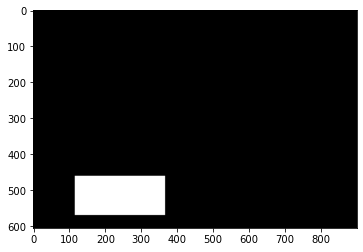

In [61]:
plt.imshow(mask_bkbg_img)